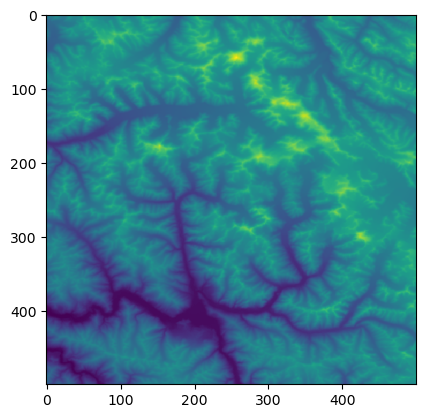

In [5]:
from osgeo import gdal
import os
import matplotlib.pyplot as plt

#os.chdir(os.path.abspath(os.path.dirname(__file__)))

ds = gdal.Open('./tests/data/dem500.tif')
band_data = ds.GetRasterBand(1).ReadAsArray()
geoTransform = ds.GetGeoTransform()

# draw band_data
import matplotlib.pyplot as plt
plt.imshow(band_data[:500, :500])
plt.show()

In [6]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator as Interpolator, interp1d
from enum import IntEnum
from typing import Dict
from math import floor


class Crossing(IntEnum):
    Y_ONLY = 1
    X_ONLY = 2

class BaseAlgorithm():
    """原则：
    1. 算法中所有点的坐标都采用 DEM 矩阵坐标
    2. DEM 矩阵的 [0, 0] 对应最左上角像元的中点，即 ( ymax - yunit / 2, xmin + xunit / 2 )
                                                (      i          ,        j         )
    3. 可以使用 i2f 和 f2i 相互转换，注意 f2i 只能给出点所在的具体索引。
    """
    def __init__(self, transform: Dict, dem: np.ndarray) -> None:
        self.xmin = transform[0]
        self.ymax = transform[3]
        self.xmax = self.xmin + dem.shape[1] * transform[1]
        self.ymin = self.ymax + dem.shape[0] * transform[5]

        self.xunit = transform[1]
        self.yunit = -transform[5]

        self.dem = dem  # 注意 [0, 0] 位置对应的经纬度应该是 (ymax, xmin)，换言之
        x = np.arange(dem.shape[0])
        y = np.arange(dem.shape[1])
        self.interp_dem = Interpolator((x, y), dem)

    def i2f(self, i: int, j: int):
        # 给定栅格索引，返回栅格单元的中心点的经纬度
        return self.ymax - (i + 0.5) * self.yunit, self.xmin + (j + 0.5) * self.xunit

    def f2i(self, y: float, x: float):
        # 给定某经纬度，返回所属于的栅格单元索引
        return floor((self.ymax - y) / self.yunit), floor((x - self.xmin) / self.xunit)

    def crossing_points(self, startf, endi, crossing=Crossing.X_ONLY) -> np.ndarray:
        # 根据选择的交叉类型对所有数据进行插值
        starti = self.f2i(*startf)
        if starti == endi:
            return np.array([starti[0]]), np.array([starti[1]])
        if crossing == Crossing.X_ONLY:
            i = np.linspace(starti[0], endi[0], abs(endi[0] - starti[0]) + 1)
            f = interp1d([starti[0], endi[0]], [starti[1], endi[1]])
            j = f(i)
        else:
            j = np.linspace(starti[1], endi[1], abs(endi[1] - starti[1]) + 1)
            f = interp1d([starti[1], endi[1]], [starti[0], endi[0]])
            i = f(j)
        i[0],j[0],i[-1],j[-1] = starti[0],starti[1],endi[0],endi[1]
        return i, j  # 获得每个交点坐标

    def interpolate_los(
        self,
        i: np.ndarray,
        j: np.ndarray,
        start_ele: float,
        end_ele: float,
        crossing=Crossing.X_ONLY
    ) -> np.ndarray:
        #print(i)
        #print(j)
        # 求 LOS 线在每个整点处的插值高程
        if crossing == Crossing.X_ONLY:
            locs = [i[0], i[-1]]
            indice = i
        else:
            locs = [j[0], j[-1]]
            indice = j

        elevs = [start_ele, end_ele]
        f = interp1d(locs, elevs)

        # interpolate from starti to endi
        return f(indice)

    def interpolate_elev(self, i, j):
        # 求 LOS 线在每个整点处的 DEM 高程插值
        #print(i,j)
        #print(np.dstack((i, j)))
        interp_elev = self.interp_dem(np.dstack((i, j)))[0]
        return interp_elev

# R3 Algorithm

In [7]:
def R3Algorithm(dem_path, startf, start_elev=0, solution = "slope"):
    ds = gdal.Open(dem_path)
    band_data = ds.GetRasterBand(1).ReadAsArray()
    geoTransform = ds.GetGeoTransform()

    # draw band_data
    plt.imshow(band_data[:500, :500])
    plt.show()
    
    print(band_data.shape)
    
    alg = BaseAlgorithm(geoTransform, band_data)

    viewshed_res = np.zeros(band_data.shape, bool)
    starti = alg.f2i(*startf)

    # 使用vectorize函数，会将列表形式的多个终点坐标拆成单个数作为参数传入，而不会保留tuple
    # vectorize 并没有加速
    
    """y_crossing = []
    x_crossing = [] 
    for x in range(band_data.shape[0]):
        for y in range(band_data.shape[1]):
            if abs(starti[0] - x) < abs(starti[1] - y):
                y_crossing.append([x,y])
            else:
                x_crossing.append([x,y])

    ViewshedForAll(alg, startf, x_crossing, Crossing.X_ONLY, start_elev=start_elev, res=viewshed_res)
    ViewshedForAll(alg, startf, y_crossing, Crossing.Y_ONLY, start_elev=start_elev, res=viewshed_res)"""
    
    for y in range(band_data.shape[0]):
        for x in range(band_data.shape[1]):
            #print(y,x)
            if abs(starti[0] - y) < abs(starti[1] - x):
                ViewshedForPair(alg, startf, (y,x), Crossing.Y_ONLY, start_elev=start_elev+alg.dem[starti[0],starti[1]], res=viewshed_res, solution=solution)
            else:
                ViewshedForPair(alg, startf, (y,x), Crossing.X_ONLY, start_elev=start_elev+alg.dem[starti[0],starti[1]], res=viewshed_res, solution=solution)
    #print(viewshed_res)
    return viewshed_res
    
def ViewshedForPair(alg, startf: tuple, endi, crossing, start_elev=0, res=None, solution = "height"):
    # 首先求视点和边界点连线与各个像元的交点
    # crossing 表示交点出现在 x 轴上还是 y 轴上
    # 返回一串点集的索引坐标插值，保证 i j 范围永远在矩阵的索引之内。
    starti = alg.f2i(*startf)
    if starti == endi:
        if res is not None:
            res[endi[0]][endi[1]] = True
        return True
    i, j = alg.crossing_points(startf, endi, crossing)
    shp = np.dstack((i, j))[0].shape
    #print(i.shape)
    #print(np.dstack((i,j)).shape)
    #print(starti,endi,crossing)
    #print('共有 {} 个交点'.format(shp[0]))
    # 求视点和边界点连线上的所有交点的高程插值
    interpolated_elev = alg.interpolate_elev(i, j)
    if alg.dem[int(i[0]), int(j[0])] != interpolated_elev[0] or alg.dem[int(i[-1]), int(j[-1])] != interpolated_elev[-1]:
        print(alg.dem[int(i[0]), int(j[0])],interpolated_elev[0], alg.dem[int(i[-1]), int(j[-1])], interpolated_elev[-1])
    #assert alg.dem[int(i[0]), int(j[0])] == interpolated_elev[0] and alg.dem[int(i[-1]), int(j[-1])] == interpolated_elev[-1]

    # 求视点和边界点 LOS 上所有交点的高程插值
    interpolated_los = alg.interpolate_los(
        i, j, start_elev, alg.dem[endi[0], endi[1]], crossing)
    assert start_elev == interpolated_los[0]
    assert alg.dem[endi[0], endi[1]] == interpolated_los[-1]
    assert interpolated_elev.shape == interpolated_los.shape # 两者插值交点个数是否一致
    if solution == "height":
        visible = np.all(interpolated_los >= interpolated_elev)
    elif solution == "slope":
        try:
            angs = (interpolated_elev[1:] - start_elev) / np.sqrt((i[1:] - starti[0])**2 + (j[1:] - starti[1])**2)
            visible =(angs.max() == angs[-1])
        except:
            print(i,j,interpolated_los,interpolated_elev,angs)
    if res is not None:
        res[endi[0]][endi[1]] = visible
    return visible


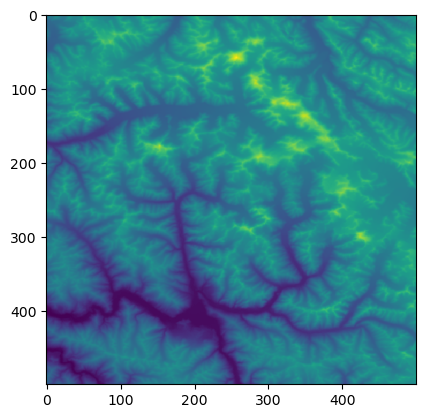

(500, 500)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


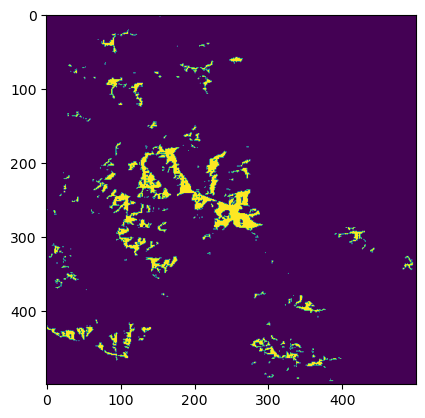

In [21]:
viewshedres = R3Algorithm('./tests/data/dem500.tif', (35.4708,76.5656), 0, solution="slope")
plt.imshow(viewshedres)
plt.show()

# R2 Algorithm

In [20]:
def R2Algorithm(dem_path, startf, start_elev=0):
    ds = gdal.Open(dem_path)
    band_data = ds.GetRasterBand(1).ReadAsArray()
    geoTransform = ds.GetGeoTransform()

    # draw band_data
    plt.imshow(band_data[:500, :500])
    plt.show()
    
    print(band_data.shape)
    
    alg = BaseAlgorithm(geoTransform, band_data)
    
    viewshed_res = np.full_like(band_data,1, int)
    distance_map = np.full_like(band_data, 10000, float)
    
    starti = alg.f2i(*startf)
    distance_map[starti[0],starti[1]] = 0
    viewshed_res[starti[0],starti[1]] = True
    
    # recognising edge pixels
    x_crossing = []
    y_crossing = []
    for x in [0, band_data.shape[1]-1]:
        for y in range(band_data.shape[0]):
            if abs(starti[0] - y) > abs(starti[1] - x):
                x_crossing.append((y,x))
            else:
                y_crossing.append((y,x))

    for y in [0, band_data.shape[0]-1]:
        for x in range(1, band_data.shape[1]-1):
            if abs(starti[0] - y) > abs(starti[1] - x):
                x_crossing.append((y,x))
            else:
                y_crossing.append((y,x))

    for endi in x_crossing:
        VieshedForPairWithAngle(alg, startf, endi, Crossing.X_ONLY, 
                                start_elev=start_elev+alg.dem[starti[0],starti[1]], 
                                res=viewshed_res, 
                                dist_map=distance_map, 
                                ang_map=angle_map)
    for endi in y_crossing:
        VieshedForPairWithAngle(alg, startf, endi, Crossing.Y_ONLY, 
                                start_elev=start_elev+alg.dem[starti[0],starti[1]], 
                                res=viewshed_res, 
                                dist_map=distance_map, 
                                ang_map=angle_map)
    print(distance_map)
    return viewshed_res

def VieshedForPairWithAngle(alg, startf: tuple, endi, crossing, start_elev=0, res=None, ang_map=None, dist_map=None):
    i, j = alg.crossing_points(startf, endi, crossing)
    starti = alg.f2i(*startf)
    
    if starti == endi:
        return

    # 求视点和边界点连线上的所有交点的高程插值
    interpolated_elev = alg.interpolate_elev(i, j)
    # 求视点和边界点 LOS 上所有交点的高程插值
    interpolated_los = alg.interpolate_los(
        i, j, start_elev, alg.dem[endi[0], endi[1]], crossing)
    assert start_elev == interpolated_los[0]
    assert alg.dem[endi[0], endi[1]] == interpolated_los[-1]
    assert interpolated_elev.shape == interpolated_los.shape # 两者插值交点个数是否一致
    
    # 去除起点
    i = i[1:]
    j = j[1:]
    interpolated_elev = interpolated_elev[1:]
    interpolated_los = interpolated_los[1:]
    #angs = np.arctan((interpolated_elev - start_elev) / np.sqrt((i - starti[0])**2 + (j - starti[1])**2))
    angs = (interpolated_elev - start_elev) / np.sqrt((i - starti[0])**2 + (j - starti[1])**2)
    for k in range(len(angs)):
        if crossing == Crossing.X_ONLY:
            left = floor(j[k])
            right = left +1 if left != j[k] else left
            #print(left, right, j[k])
            if j[k]-left < dist_map[int(i[k]), left]:
                dist_map[int(i[k]), left] = j[k]-left
                res[int(i[k]),left] = (angs[:k+1].max() == angs[k])
            if right-j[k] < dist_map[int(i[k]), right]:
                dist_map[int(i[k]), right] = right-j[k]
                res[int(i[k]),right] = (angs[:k+1].max() == angs[k])
        if crossing == Crossing.Y_ONLY:
            left = floor(i[k])
            right = left+1 if left != i[k] else left
            if i[k]-left < dist_map[left, int(j[k])]:
                dist_map[left, int(j[k])] = i[k]-left
                res[left, int(j[k])] = (angs[:k+1].max() == angs[k])
            if right-i[k] < dist_map[right, int(j[k])]:
                dist_map[right, int(j[k])] = right-i[k]
                res[right, int(j[k])] = (angs[:k+1].max() == angs[k])


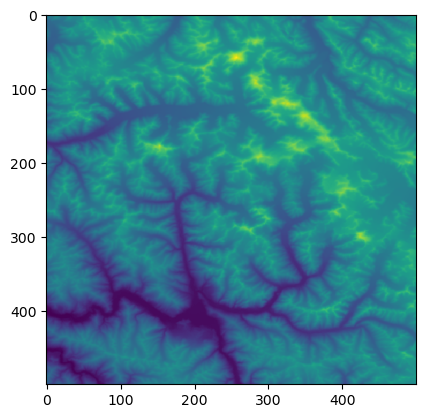

(500, 500)
[[10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 ...
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]]
996
1000
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.06382979 0.06049822 ... 0.18181818 0.1780303  0.        ]
 [0.         0.06737589 0.12765957 ... 0.35606061 0.17490494 0.        ]
 ...
 [0.         0.17021277 0.33333333 ... 0.15319149 0.07264957 0.        ]
 [0.         0.16666667 0.16370107 ... 0.08085106 0.07659574 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


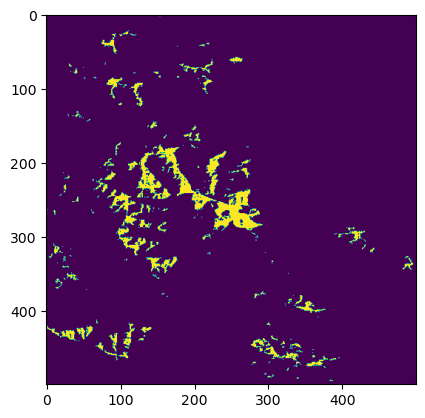

In [21]:
viewshedres_r2 = R2Algorithm('./tests/data/dem500.tif', (35.4708,76.5656), 0)
#viewshedres_r3 = R3Algorithm('./tests/data/dem500.tif', (35.4708,76.5656), 6447)
plt.imshow(viewshedres_r2)
plt.show()
#plt.imshow(viewshedres_r3)
#plt.show()